In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

engine = "h5netcdf"

file = r"C:\Users\david\PythonProjekte\physicsnemoKIDS\examples\weather\ProjektModelle\David\hrrr_mini\hrrr_mini_train.nc"
ds = xr.open_dataset(file, engine = engine)

print(ds)     
print(ds.coord)         



<xarray.Dataset> Size: 1MB
Dimensions:  (sample: 100000, coord: 2)
Coordinates:
    coord    (sample, coord) uint16 400kB ...
Dimensions without coordinates: sample
Data variables:
    time     (sample) datetime64[ns] 800kB ...
<xarray.DataArray 'coord' (sample: 100000, coord: 2)> Size: 400kB
[200000 values with dtype=uint16]
Coordinates:
    coord    (sample, coord) uint16 400kB ...
Dimensions without coordinates: sample


In [3]:
print("\n--- GROUPS ---")
try:
    import h5netcdf
    with h5netcdf.File(file, 'r') as f:
        print("Available groups:", list(f.keys()))
        
        for group_name in f.keys():
            if group_name != '/':          
                print(f"\nGroup: {group_name}")
                
                group_ds = xr.open_dataset(file, group=group_name)
                print(group_ds)
                group_ds.close()
except Exception as e:
    print(f"No groups or error accessing groups: {e}")

ds.close()


--- GROUPS ---
Available groups: ['input', 'output', 'invariant', 'time', 'coord']

Group: input
No groups or error accessing groups: DLL load failed while importing _netCDF4: Die angegebene Prozedur wurde nicht gefunden.


In [4]:
input_ds = xr.open_dataset(file, group= "input", engine=engine)
print(input_ds)

<xarray.Dataset> Size: 666MB
Dimensions:  (sample: 100000, y_lr: 8, x_lr: 8)
Dimensions without coordinates: sample, y_lr, x_lr
Data variables: (12/26)
    u10m     (sample, y_lr, x_lr) float32 26MB ...
    v10m     (sample, y_lr, x_lr) float32 26MB ...
    t2m      (sample, y_lr, x_lr) float32 26MB ...
    tcwv     (sample, y_lr, x_lr) float32 26MB ...
    sp       (sample, y_lr, x_lr) float32 26MB ...
    msl      (sample, y_lr, x_lr) float32 26MB ...
    ...       ...
    t500     (sample, y_lr, x_lr) float32 26MB ...
    t250     (sample, y_lr, x_lr) float32 26MB ...
    q1000    (sample, y_lr, x_lr) float32 26MB ...
    q850     (sample, y_lr, x_lr) float32 26MB ...
    q500     (sample, y_lr, x_lr) float32 26MB ...
    q250     (sample, y_lr, x_lr) float32 26MB ...


In [5]:
output_ds = xr.open_dataset(file, group="output", engine=engine)
print(output_ds)

<xarray.Dataset> Size: 7GB
Dimensions:  (sample: 100000, y_hr: 64, x_hr: 64)
Dimensions without coordinates: sample, y_hr, x_hr
Data variables:
    2t       (sample, y_hr, x_hr) float32 2GB ...
    10u      (sample, y_hr, x_hr) float32 2GB ...
    10v      (sample, y_hr, x_hr) float32 2GB ...
    tp       (sample, y_hr, x_hr) float32 2GB ...


In [6]:
invariant_ds = xr.open_dataset(file, group="invariant", engine=engine)
print(invariant_ds)

<xarray.Dataset> Size: 30MB
Dimensions:    (y_grid: 1059, x_grid: 1799)
Dimensions without coordinates: y_grid, x_grid
Data variables:
    latitude   (y_grid, x_grid) float32 8MB ...
    longitude  (y_grid, x_grid) float32 8MB ...
    elev_mean  (y_grid, x_grid) float32 8MB ...
    lsm_mean   (y_grid, x_grid) float32 8MB ...


In [7]:
time = ds["time"]
coord = ds["coord"]

print(time)
print(coord)

<xarray.DataArray 'time' (sample: 100000)> Size: 800kB
[100000 values with dtype=datetime64[ns]]
Dimensions without coordinates: sample
<xarray.DataArray 'coord' (sample: 100000, coord: 2)> Size: 400kB
[200000 values with dtype=uint16]
Coordinates:
    coord    (sample, coord) uint16 400kB ...
Dimensions without coordinates: sample


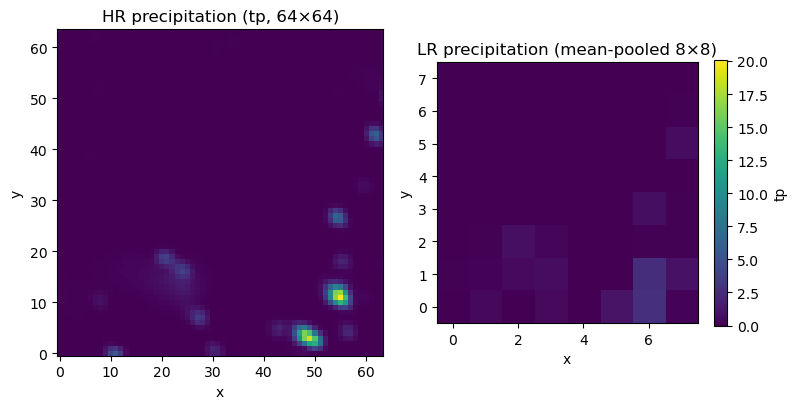

In [25]:
sample_idx = 2000
tp_hr = output_ds["tp"].isel(sample=sample_idx).values
tp_hr = np.clip(tp_hr, 0, None)

H, W = tp_hr.shape  
factor_y = H // 8
factor_x = W // 8


tp_lr = tp_hr.reshape(8, factor_y, 8, factor_x).mean(axis=(1, 3))

vmin = tp_hr.min()
vmax = tp_hr.max()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

im0 = axes[0].imshow(tp_hr, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
axes[0].set_title("HR precipitation (tp, 64×64)")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

im1 = axes[1].imshow(tp_lr, origin="lower", cmap="viridis", vmin=vmin, vmax=vmax)
axes[1].set_title("LR precipitation (mean-pooled 8×8)")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

y0_hr, x0_hr = 10, 10
h_hr, w_hr = 30, 30


y0_lr, x0_lr = y0_hr / factor_y, x0_hr / factor_x
h_lr, w_lr = h_hr / factor_y, w_hr / factor_x



cbar = fig.colorbar(im0, ax=axes[1], shrink=0.8)
cbar.set_label("tp")

plt.tight_layout()
plt.show()